In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from wrf_helpers import get_zgrid_meanProfiles as zgrid
from pandas import to_datetime

In [2]:
save=True
savename='profiles_diffusivities'

In [3]:
path = "../WRFV3/LES3"
file= "wrfout_d01_2014-03-21_12:00:00"

ds = xr.open_dataset(path+'/'+file)#+'.nc')
ds

<xarray.Dataset>
Dimensions:                (Time: 121, south_north: 149, west_east: 399,
                            bottom_top: 68, bottom_top_stag: 69,
                            soil_layers_stag: 4, west_east_stag: 400,
                            south_north_stag: 150)
Coordinates:
    XLAT                   (Time, south_north, west_east) float32 ...
    XLONG                  (Time, south_north, west_east) float32 ...
    XTIME                  (Time) datetime64[ns] ...
    XLAT_U                 (Time, south_north, west_east_stag) float32 ...
    XLONG_U                (Time, south_north, west_east_stag) float32 ...
    XLAT_V                 (Time, south_north_stag, west_east) float32 ...
    XLONG_V                (Time, south_north_stag, west_east) float32 ...
Dimensions without coordinates: Time, south_north, west_east, bottom_top,
                                bottom_top_stag, soil_layers_stag,
                                west_east_stag, south_north_stag
Data variables: (12/153)
    Times                  (Time) |S19 ...
    LU_INDEX               (Time, south_north, west_east) float32 ...
    ZNU                    (Time, bottom_top) float32 ...
    ZNW                    (Time, bottom_top_stag) float32 ...
    ZS                     (Time, soil_layers_stag) float32 ...
    DZS                    (Time, soil_layers_stag) float32 ...
    ...                     ...
    PCB                    (Time, south_north, west_east) float32 ...
    PC                     (Time, south_north, west_east) float32 ...
    LANDMASK               (Time, south_north, west_east) float32 ...
    LAKEMASK               (Time, south_north, west_east) float32 ...
    SST                    (Time, south_north, west_east) float32 ...
    SST_INPUT              (Time, south_north, west_east) float32 ...
Attributes: (12/119)
    TITLE:                            OUTPUT FROM WRF V3.9.1.1 MODEL
    START_DATE:                      2014-03-21_12:00:00
    SIMULATION_START_DATE:           2014-03-21_12:00:00
    WEST-EAST_GRID_DIMENSION:        400
    SOUTH-NORTH_GRID_DIMENSION:      150
    BOTTOM-TOP_GRID_DIMENSION:       69
    ...                              ...
    ISLAKE:                          0
    ISICE:                           0
    ISURBAN:                         0
    ISOILWATER:                      0
    HYBRID_OPT:                      -1
    ETAC:                            0.0

In [4]:
time = b'2014-03-22_04:20:00'
itime = ds['Times'].values.tolist().index(time)
timeStr = time.decode('utf-8')
time = to_datetime(timeStr, format='%Y-%m-%d_%H:%M:%S')

In [5]:
nx = ds.sizes['west_east']
dx = ds.attrs['DX']
xplot = 9975. + 1000 + 1550 # or + 550 b/c 
xcv = np.arange(dx/2,nx*dx,dx)
ix = np.where(xcv == xplot)[0][0]

In [6]:
ztop = 50 # [m a.s.l.]
ktop = 12 # just for speed, make sure higher than ztop everywhere
zc, _ = zgrid(ds, itime, ktop, ix)
z=zc[:,0]
Km_wrf = ds['XKMV'][itime,:ktop,:,ix].mean(dim="south_north")
Kh_wrf = ds['XKHV'][itime,:ktop,:,ix].mean(dim="south_north")

In [7]:
Pr_wrf=Km_wrf/Kh_wrf
print(Pr_wrf.mean())

<xarray.DataArray ()>
array(0.79517865, dtype=float32)
Coordinates:
    XTIME    datetime64[ns] 2014-03-22T04:20:00


In [8]:
n = np.linspace(0,ztop,100)

In [9]:
C = 0.008
h = 20

Kh = C * n * np.exp( -0.5 * n**2 / h**2 )

In [10]:
Pr = 0.75

Km = Pr*Kh

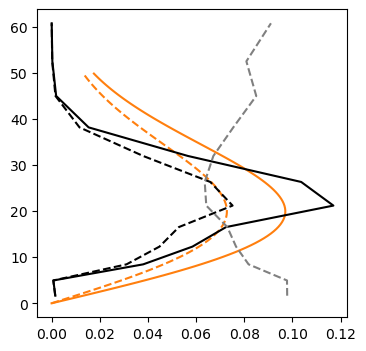

In [11]:
try:
    del(fig, axs)
    print("deleted old figure")
    fig, axs = plt.subplots( 1, 1, figsize=(4, 4) )
except:
    fig, axs = plt.subplots( 1, 1, figsize=(4, 4) )

slope=3*np.pi/180.

axs.plot( Kh, n*np.cos(slope),  color="tab:orange", label = r'GO K$_h$')
axs.plot( Km, n*np.cos(slope), color="tab:orange", linestyle = '--',label = r'GO K$_m$' )

axs.plot( Kh_wrf, z, 'k', label = r'LES3 K$_h$')
axs.plot( Km_wrf, z, 'k', linestyle = '--', label = r'LES3 K$_m$' )
Prline = axs.plot( Pr_wrf*1e-1, z, 'gray', linestyle = '--', label = r'LES3 Pr/10' )

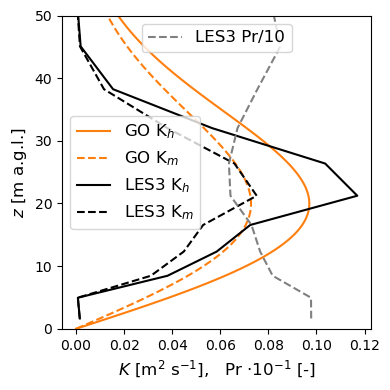

In [12]:
axs.set_ylim( (-.1, ztop) )
handles,labels=axs.get_legend_handles_labels()
leg = axs.legend(handles=handles[:-1],labels=labels[:-1],fontsize=12,loc='center left')#,bbox_to_anchor=(1.02, 1.02))
axs.add_artist(leg)
axs.legend(handles=[handles[-1]],labels=[labels[-1]],fontsize=12,loc='upper center')
axs.set_ylabel(r"$z$ [m a.g.l.]",size=12)
axs.set_xlabel(r'$K$ [m$^2$ s$^{-1}$],   Pr $\cdot$10$^{-1}$ [-]',size=12)
fig.tight_layout() 

fig

In [13]:
if save:
    plt.figure(fig)
    fmts=["png","eps"]
    for fmt in fmts:
        plt.savefig("plots/"+savename+"."+fmt, format=fmt)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
